In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import xesmf as xe
import sys
import gc
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/home/brayan/mnsun/')
from utils import check_dir

In [2]:
def wind_to_stress(U, V):
    """
    Fucnion para convertir vientos a esfuerzo de vientos
    
    Imputs: U --> Array (time,lat,lon)
            V --> Array (time,lat,lon)
    Outputs:
            TX --> Array (time,lat,lon)
            TY --> Array (time,lat,lon)    
    """
    wind     = np.sqrt(U**2+V**2)
    rho      = 1.225
    C_d      = 0.0013
    
    return np.float32(wind*rho*C_d*U), np.float32(wind*rho*C_d*V)

def anom_clim( DATA_, lead_):
    DATA_0         = DATA_.resample(time="1MS").mean(dim="time")
    DATA_1         = DATA_0-DATA_0.mean(dim = ("time"))
    DATA_2         = (DATA_1.groupby('time.month').sum(dim='time')/int(DATA_.time.shape[0]/365))
    # Building climatology
    DATA_2_forward = DATA_2.copy()
    DATA_2_back    = DATA_2.copy()
    DATA_2_back["month"]    = pd.date_range("1903-01-01", "1903-12-31", freq="MS").shift(14, freq='D')
    DATA_2["month"]         = pd.date_range("1904-01-01", "1904-12-31", freq="MS").shift(14, freq='D')
    DATA_2_forward["month"] = pd.date_range("1905-01-01", "1905-12-31", freq="MS").shift(14, freq='D') 
    DATA_3                  = xr.concat([DATA_2_back, DATA_2, DATA_2_forward], dim="month").chunk(chunks={'month': 36})
    DATA_4                  = DATA_3.interp(month=pd.date_range("1903-01-01", "1905-12-31", freq="D"), method="cubic").sel(month=slice("1904-01-01", "1904-12-31"))    
    DATA_4                  = DATA_4.rename({"month":"dayofyear"})
    DATA_4["dayofyear"]     = np.arange(1,366+1,1, dtype=int)
    DATA_5                  = DATA_4.chunk(chunks={'dayofyear': 1}) + DATA_0.mean(dim = ("time"))
    Clim                    = DATA_5.roll(dayofyear=lead_)
    Clim["lead"]            = np.arange(lead_, lead_+1)   
    # Anomalies
    Anom                       = DATA_.groupby("time.dayofyear") - DATA_5
    Anom["time"]               = pd.date_range(str(Anom.time[0].values)[:10],str(Anom.time[-1].values)[:10], freq="D").shift(lead_, freq='D')
    Anom["lead"]               = np.arange(lead_+0.5, lead_+1.5)
    return Anom, Clim

# Introduccion

* Una vez que tenemos la data cruda descargada desde S2S, AWS-NCEP y PISCO-Senamhi, debemos estandarizar, procesar y adecuar la data para implementarla al modelo de predicción.

* Por ahora solo consideramos la data del S2S para hacer el pre y postprocesamiento.

* Al momento de hacer el calculo de la climatologia, a esta data se hace el calculo del lead time (roll). Mientras que las anomalias se indica el lead time que tiene (no se hace roll).

In [3]:
levels = np.array([200,850])

In [4]:
MODELS = {"NCEP":{"reforecast":{"perturbed":{"2m_above_ground"      :{"2t"  :{"LA": np.arange(0.5,43.5+1,1),"M" : np.arange(1,3+1,1)}},
                                             "sfc_precip"           :{"tp"  :{"L1": np.arange(1,44+1,1)     ,"M" : np.arange(1,3+1,1)}},
                                             "sfc_temperature"      :{"wtmp":{"LB": np.arange(1.5,43.5+1,1),"M" : np.arange(1,3+1,1)}},
                                             "10m_above_ground"     :{"10u"   :{"L": np.arange(0,44+1,1)     ,"M" : np.arange(1,3+1,1)},
                                                                      "10v"   :{"L": np.arange(0,44+1,1)     ,"M" : np.arange(1,3+1,1)}
                                                                      },                                               
                                             "pressure_level_1"     :{"q"   :{"L": np.arange(0,44+1,1)     ,"M" : np.arange(1,3+1,1),"P2":levels}},
                                             "pressure_level_2"     :{
                                                                      "t"   :{"L": np.arange(0,44+1,1)     ,"M" : np.arange(1,3+1,1),"P":levels}
                                                                      },
                                             "pressure_level_wind"  :{"u"   :{"L": np.arange(0,44+1,1)     ,"M" : np.arange(1,3+1,1),"P":levels},
                                                                      "v"   :{"L": np.arange(0,44+1,1)     ,"M" : np.arange(1,3+1,1),"P":levels}
                                                                      },                                                            
                                             "sfc_rad_flux"         :{"ssrd":{"L1": np.arange(1,44+1,1)     ,"M" : np.arange(1,3+1,1)},
                                                                      "strd":{"L1": np.arange(1,44+1,1)     ,"M" : np.arange(1,3+1,1)}},
                                             },
                                 "control"  :{"2m_above_ground"      :{"2t"  :{"LA": np.arange(0.5,43.5+1,1)}},
                                              "sfc_precip"           :{"tp"  :{"L1": np.arange(1,44+1,1)     }},
                                              "sfc_temperature"      :{"wtmp":{"LB": np.arange(1.5,43.5+1,1)}},
                                              "10m_above_ground"     :{"10u"   :{"L": np.arange(0,44+1,1)     },
                                                                       "10v"   :{"L": np.arange(0,44+1,1)     }
                                                                       },                                               
                                              "pressure_level_1"     :{"q"   :{"L": np.arange(0,44+1,1)     ,"P2":levels}},
                                              "pressure_level_2"     :{
                                                                       "t"   :{"L": np.arange(0,44+1,1)     ,"P":levels}
                                                                       },
                                              "pressure_level_wind"  :{"u"   :{"L": np.arange(0,44+1,1)     ,"P":levels},
                                                                       "v"   :{"L": np.arange(0,44+1,1)     ,"P":levels}
                                                                       },   
                                              "sfc_rad_flux"         :{"ssrd":{"L1": np.arange(1,44+1,1)},
                                                                       "strd":{"L1": np.arange(1,44+1,1)}}                                                         
                                              }
                                },
                 }
         }

In [5]:
Descript_dataset = {"Insta_dataset"    : ["pressure_level_1", "pressure_level_2","pressure_level_wind","sfc_rad_flux","10m_above_ground"],
                    "Mean_dataset"     : ["2m_above_ground", "sfc_temperature"]}

In [6]:
INPUT_DATA  = "/media/brayan/TOSHIBA_EXT/DATA/RAW_DATA/S2S/" #"/home/brayan/DATA/S2S/raw_data/" #
OUTPUT_DIR  = "/home/brayan/DATA/MODEL-FORECAST/NCEP/"
dataset     = "10m_above_ground"
resolucion_scale = 1  # 1-->normal (1.5x1.5), 2--> 200% (3x3), 4 --> 400% (6x6) 

In [7]:
for model_name, v_1 in MODELS.items():
    if model_name in OUTPUT_DIR:
        print("LA SALIDA CONCUERDA CON EL MODELO DESCARGADO")
    else:
        break
    for type_sim, v_2 in v_1.items():
        for type_ini, v_3 in v_2.items():
            for var_cat, v_4 in v_3.items():
                if var_cat != dataset:                  
                    continue
                dic_inf = {}
                for sc, vs  in zip(list(v_4.keys()),list(v_4.values())): 
                    dic_inf[sc] = vs
                if dataset in Descript_dataset["Insta_dataset"]:  # Si el dataset tiene registros instantaneos diarios (generalmente 0000)
                    if type_ini == "control":
                        v_5 = dic_inf[list(dic_inf.keys())[0]]  #Se asume que ambas suvbcategorias tienen el mismo grillado L
                        des = list(v_5.keys())   
                        for en_1, cnt_1 in enumerate(v_5[des[0]][:-1]):
                            if cnt_1 == 0: #Para omitir el dia cero de inicializacion
                                continue
                            if 2 == len(des):  # Si existen dos niveles
                                for cnt_2,levels in enumerate(v_5[des[1]]):
                                    if len(list(dic_inf.keys())) == 1:
                                        print("COmienza denuevo")
                                        MODEL_DATA_X_pre  = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[0]}/{dataset}_{list(v_4.keys())[0]}_{des[0]}{str(cnt_1)}_{des[1]}{str(cnt_2)}.nc"
                                        MODEL_DATA_X_post = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[0]}/{dataset}_{list(v_4.keys())[0]}_{des[0]}{str(cnt_1+1)}_{des[1]}{str(cnt_2)}.nc"                                    
                                        
                                        # Leemos la data y seleccionamos la region intertropical
                                        DATAX_0 = xr.open_dataset(MODEL_DATA_X_pre).sel(Y=slice(30,-30))
                                        DATAX_1 = xr.open_dataset(MODEL_DATA_X_post).sel(Y=slice(30,-30))
                                        
                                        # Convertimos a float 32 numpy array
                                        TX_0 = np.float32(getattr(DATAX_0, list((dic_inf.keys()))[0]).values)
                                        TX_1 = np.float32(getattr(DATAX_1, list((dic_inf.keys()))[0]).values)                                        
                                        
                                        # Hacer el calculo para el promedio diario
                                        TX_array  =  xr.DataArray((TX_0.squeeze().reshape((TX_0.shape[0],1,TX_0.shape[-2],TX_0.shape[-1]))[:,:,::-1,:] + TX_1.squeeze().reshape((TX_0.shape[0],1,TX_0.shape[-2],TX_0.shape[-1]))[:,:,::-1,:])/2,  ###La inversion en lat se hace porque la latitud esta en orden descendente
                                                                  coords=[DATAX_0.S, np.array([cnt_1+0.5]) , DATAX_0.Y.values[::-1], DATAX_0.X],
                                                                  dims=["time","lead","lat","lon"])  
                                        # Liberar espacio de memoria
                                        DATAX_0.close()
                                        DATAX_1.close()
                                        del TX_0
                                        del TX_1 
                                        gc.collect()     

                                        # Se hace una interpolacion en el tiempo para algunos datos faltantes (generalmente en la dimension tiempo)
                                        TX_array_fill = TX_array.interpolate_na(dim="time", method="cubic", fill_value="extrapolate")                                        
                                        # Liberar espacio de memoria
                                        TX_array.close()
                                        gc.collect()                                        
                                        
                                        # Regrillado del dataset (bajar resolucion)
                                        if resolucion_scale > 1:
                                            ds_RES         = xr.Dataset(
                                                                        {'lon':(['lon'], np.arange(TX_array_fill.lon.values[0],TX_array_fill.lon.values[-1], 1.5*resolucion_scale)),  
                                                                         'lat':(['lat'], np.arange(TX_array_fill.lat.values[0],TX_array_fill.lat.values[-1], 1.5*resolucion_scale))}  ## 1.5 es el anchod e grilla original
                                                                        )
                                            regridder      = xe.Regridder(TX_array_fill, ds_RES, "bilinear") 
                                            regridder.clean_weight_file() 
                                            TX_res         = regridder(TX_array_fill).values    
                                            TX_array_RES   =  xr.DataArray(np.float32(TX_res),
                                                                           coords=[TX_array_fill.time, np.array([cnt_1+0.5]) , ds_RES.lat, ds_RES.lon],
                                                                           dims=["time","lead","lat","lon"])

                                            # Liberar espacio de memoria
                                            TX_array_fill.close()
                                            del TX_res
                                            gc.collect()    
                                        else:
                                            TX_array_RES = TX_array_fill
                                        
                                        # Calculo de Anomalias y Climatologias
                                        TX_anom_RES, TX_Clim_RES = anom_clim( TX_array_RES, cnt_1)
                                        TX_array_RES.close()
                                        gc.collect()  
                                        
                                        # Extraemos la media y escalamos respecto a la desviacion estandar, si es una variable oceanica entonces devuelve cero
                                        TX_anom_std   = ((TX_anom_RES-TX_anom_RES.mean("time"))/TX_anom_RES.std("time")).fillna(0)  #Por ahora aplicaremos la normalizacion estandar, pero debemos analizar otras opciones  #https://empresas.blogthinkbig.com/precauciones-la-hora-de-normalizar/
                                        
                                        # Convertimos a Dataset
                                        ANOM_X        = xr.Dataset({"a_"+list((dic_inf.keys()))[0]: TX_anom_std})
                                        CLIM_X        = xr.Dataset({"clim_"+list((dic_inf.keys()))[0]: TX_Clim_RES, "mean": TX_anom_RES.mean("time"), "std": TX_anom_RES.std("time")})                                           

                                        # Creamos las carpetas de las variables
                                        check_dir(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"."+str(levels)+"/CLIMATOLOGIA/")
                                        check_dir(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"."+str(levels)+"/ANOMALIAS/")                                        
                                        
                                        # Guardamos la data
                                        if cnt_1 == 1:
                                            CLIM_X.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"."+str(levels)+"/CLIMATOLOGIA/"+f"Climatologia_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                                                           mode="w", consolidated=True)
                                            ANOM_X.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"."+str(levels)+"/ANOMALIAS/"+f"Anomalias_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                                                           mode="w", consolidated=True)   
                                        else:
                                            CLIM_X.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"."+str(levels)+"/CLIMATOLOGIA/"+f"Climatologia_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                                                           mode="a", consolidated=True, append_dim="lead")
                                            ANOM_X.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"."+str(levels)+"/ANOMALIAS/"+f"Anomalias_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                                                           mode="a", consolidated=True, append_dim="lead")                                               
                                        ANOM_X.close()
                                        CLIM_X.close()
                                        gc.collect()
                                        print("vemos: " + str(cnt_1), levels) 
                                        
                                        

                                    elif len(list(dic_inf.keys())) == 2:  # Si existen dos variables
                                        MODEL_DATA_X_pre  = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[0]}/{dataset}_{list(v_4.keys())[0]}_{des[0]}{str(cnt_1)}_{des[1]}{str(cnt_2)}.nc"
                                        MODEL_DATA_Y_pre  = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[1]}/{dataset}_{list(v_4.keys())[1]}_{des[0]}{str(cnt_1)}_{des[1]}{str(cnt_2)}.nc"
                                        MODEL_DATA_X_post = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[0]}/{dataset}_{list(v_4.keys())[0]}_{des[0]}{str(cnt_1+1)}_{des[1]}{str(cnt_2)}.nc"
                                        MODEL_DATA_Y_post = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[1]}/{dataset}_{list(v_4.keys())[1]}_{des[0]}{str(cnt_1+1)}_{des[1]}{str(cnt_2)}.nc"                                                                

#                                         print(MODEL_DATA_X_pre)
#                                         print(MODEL_DATA_X_post)
#                                         print(MODEL_DATA_Y_pre)
#                                         print(MODEL_DATA_Y_post)                                    
                                        print("A2")
                            else:
                                if len(list(dic_inf.keys())) == 1:  #Si existe solo una sola variable
                                    MODEL_DATA_X_pre   = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[0]}/{dataset}_{list(v_4.keys())[0]}_{des[0]}{str(cnt_1)}.nc"
                                    MODEL_DATA_X_post  = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[0]}/{dataset}_{list(v_4.keys())[0]}_{des[0]}{str(cnt_1+1)}.nc"
#                                     print(MODEL_DATA_X_pre)
#                                     print(MODEL_DATA_X_post)
                                    print("B1")      

                                elif len(list(dic_inf.keys())) == 2:
                                    MODEL_DATA_X_pre  = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[0]}/{dataset}_{list(v_4.keys())[0]}_{des[0]}{str(cnt_1)}.nc"
                                    MODEL_DATA_Y_pre  = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[1]}/{dataset}_{list(v_4.keys())[1]}_{des[0]}{str(cnt_1)}.nc"
                                    MODEL_DATA_X_post = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[0]}/{dataset}_{list(v_4.keys())[0]}_{des[0]}{str(cnt_1+1)}.nc"
                                    MODEL_DATA_Y_post = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[1]}/{dataset}_{list(v_4.keys())[1]}_{des[0]}{str(cnt_1+1)}.nc"
#                                     print(MODEL_DATA_X_pre)
#                                     print(MODEL_DATA_X_post)
#                                     print(MODEL_DATA_Y_pre)
#                                     print(MODEL_DATA_Y_post)                                    
                                    print("B2")         

                                    # Leemos la data y seleccionamos la region intertropical
                                    DATAX_0 = xr.open_dataset(MODEL_DATA_X_pre).sel(Y=slice(30,-30))
                                    DATAX_1 = xr.open_dataset(MODEL_DATA_X_post).sel(Y=slice(30,-30))
                                    DATAY_0 = xr.open_dataset(MODEL_DATA_Y_pre).sel(Y=slice(30,-30))
                                    DATAY_1 = xr.open_dataset(MODEL_DATA_Y_post).sel(Y=slice(30,-30))

                                    if list((dic_inf.keys()))[0] in ["10u","10v"]:
                                        print("vientos")
                                        # Convertir a esfuerzo de vientos
                                        TX_0, TY_0 = wind_to_stress( getattr(DATAX_0, list((dic_inf.keys()))[0] ), getattr(DATAY_0, list((dic_inf.keys()))[1] ))
                                        TX_1, TY_1 = wind_to_stress( getattr(DATAX_1, list((dic_inf.keys()))[0] ), getattr(DATAY_1, list((dic_inf.keys()))[1] ))                                       
                                    else: 
                                        print("otro")
                                        # Convertimos a float 32 numpy array
                                        TX_0 = np.float32(getattr(DATAX_0, list((dic_inf.keys()))[0]).values)
                                        TX_1 = np.float32(getattr(DATAX_1, list((dic_inf.keys()))[0]).values)                                        
                                        TY_0 = np.float32(getattr(DATAY_0, list((dic_inf.keys()))[1]).values)
                                        TY_1 = np.float32(getattr(DATAY_1, list((dic_inf.keys()))[1]).values)                                                                            

                                    # Hacer el calculo para el promedio diario
                                    TX_array  =  xr.DataArray((TX_0.squeeze().reshape((TX_0.shape[0],1,TX_0.shape[-2],TX_0.shape[-1]))[:,:,::-1,:] + TX_1.squeeze().reshape((TX_0.shape[0],1,TX_0.shape[-2],TX_0.shape[-1]))[:,:,::-1,:])/2,  ###La inversion en lat se hace porque la latitud esta en orden descendente
                                                              coords=[DATAX_0.S, np.array([cnt_1+0.5]) , DATAX_0.Y.values[::-1], DATAX_0.X],
                                                              dims=["time","lead","lat","lon"])  
                                    TY_array  =  xr.DataArray((TY_0.squeeze().reshape((TY_0.shape[0],1,TY_0.shape[-2],TY_0.shape[-1]))[:,:,::-1,:] + TY_1.squeeze().reshape((TY_0.shape[0],1,TY_0.shape[-2],TY_0.shape[-1]))[:,:,::-1,:])/2,  ###La inversion en lat se hace porque la latitud esta en orden descendente
                                                              coords=[DATAY_0.S, np.array([cnt_1+0.5]) , DATAY_0.Y.values[::-1], DATAY_0.X],
                                                              dims=["time","lead","lat","lon"])                                      
                                    # Liberar espacio de memoria
                                    DATAX_0.close()
                                    DATAX_1.close()
                                    DATAY_0.close()
                                    DATAY_1.close()                                    
                                    del TX_0
                                    del TX_1
                                    del TY_0
                                    del TY_1                                    
                                    gc.collect()     

                                    # Se hace una interpolacion en el tiempo para algunos datos faltantes (generalmente en la dimension tiempo)
                                    TX_array_fill = TX_array.interpolate_na(dim="time", method="cubic", fill_value="extrapolate")
                                    TY_array_fill = TY_array.interpolate_na(dim="time", method="cubic", fill_value="extrapolate")
                                    # Liberar espacio de memoria
                                    TX_array.close()
                                    TY_array.close()
                                    gc.collect()                                        

                                    # Regrillado del dataset (bajar resolucion)
                                    if resolucion_scale > 1:
                                        ds_RES         = xr.Dataset(
                                                                    {'lon':(['lon'], np.arange(TX_array_fill.lon.values[0],TX_array_fill.lon.values[-1], 1.5*resolucion_scale)),  
                                                                     'lat':(['lat'], np.arange(TX_array_fill.lat.values[0],TX_array_fill.lat.values[-1], 1.5*resolucion_scale))}  ## 1.5 es el anchod e grilla original
                                                                    )
                                        regridder      = xe.Regridder(TX_array_fill, ds_RES, "bilinear") 
                                        regridder.clean_weight_file() 
                                        TX_res         = regridder(TX_array_fill).values   
                                        TY_res         = regridder(TY_array_fill).values   
                                        TX_array_RES   =  xr.DataArray(np.float32(TX_res),
                                                                       coords=[TX_array_fill.time, np.array([cnt_1+0.5]) , ds_RES.lat, ds_RES.lon],
                                                                       dims=["time","lead","lat","lon"])
                                        TY_array_RES   =  xr.DataArray(np.float32(TY_res),
                                                                       coords=[TY_array_fill.time, np.array([cnt_1+0.5]) , ds_RES.lat, ds_RES.lon],
                                                                       dims=["time","lead","lat","lon"])                                        
                                        # Liberar espacio de memoria
                                        TX_array_fill.close()
                                        TY_array_fill.close()
                                        del TX_res
                                        del TY_res
                                        gc.collect()    
                                    else:
                                        TX_array_RES = TX_array_fill
                                        TY_array_RES = TY_array_fill

                                    # Calculo de Anomalias y Climatologias
                                    TX_anom_RES, TX_Clim_RES = anom_clim( TX_array_RES, cnt_1)
                                    TY_anom_RES, TY_Clim_RES = anom_clim( TY_array_RES, cnt_1)
                                    TX_array_RES.close()
                                    TY_array_RES.close()
                                    gc.collect()  

                                    # Extraemos la media y escalamos respecto a la desviacion estandar, si es una variable oceanica entonces devuelve cero
                                    TX_anom_std   = ((TX_anom_RES-TX_anom_RES.mean("time"))/TX_anom_RES.std("time")).fillna(0)  #Por ahora aplicaremos la normalizacion estandar, pero debemos analizar otras opciones  #https://empresas.blogthinkbig.com/precauciones-la-hora-de-normalizar/
                                    TY_anom_std   = ((TY_anom_RES-TY_anom_RES.mean("time"))/TY_anom_RES.std("time")).fillna(0) 
                                    
                                    # Convertimos a Dataset
                                    ANOM_X        = xr.Dataset({"a_"+list((dic_inf.keys()))[0]: TX_anom_std})
                                    CLIM_X        = xr.Dataset({"clim_"+list((dic_inf.keys()))[0]: TX_Clim_RES, "mean": TX_anom_RES.mean("time"), "std": TX_anom_RES.std("time")})                                           
                                    ANOM_Y        = xr.Dataset({"a_"+list((dic_inf.keys()))[1]: TY_anom_std})
                                    CLIM_Y        = xr.Dataset({"clim_"+list((dic_inf.keys()))[1]: TY_Clim_RES, "mean": TY_anom_RES.mean("time"), "std": TY_anom_RES.std("time")})                                                                               

                                    # Creamos las carpetas de las variables
                                    check_dir(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"/CLIMATOLOGIA/")
                                    check_dir(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"/ANOMALIAS/")                                        
                                    check_dir(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[1]+"/CLIMATOLOGIA/")
                                    check_dir(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[1]+"/ANOMALIAS/")                                                                            

                                    # Guardamos la data
                                    if cnt_1 == 1:
                                        CLIM_X.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"/CLIMATOLOGIA/"+f"Climatologia_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                                                       mode="w", consolidated=True)
                                        ANOM_X.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"/ANOMALIAS/"+f"Anomalias_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                                                       mode="w", consolidated=True)   
                                        CLIM_Y.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[1]+"/CLIMATOLOGIA/"+f"Climatologia_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                                                       mode="w", consolidated=True)
                                        ANOM_Y.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[1]+"/ANOMALIAS/"+f"Anomalias_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                                                       mode="w", consolidated=True)                                           
                                    else:
                                        CLIM_X.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"/CLIMATOLOGIA/"+f"Climatologia_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                                                       mode="a", consolidated=True, append_dim="lead")
                                        ANOM_X.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"/ANOMALIAS/"+f"Anomalias_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                                                       mode="a", consolidated=True, append_dim="lead")       
                                        CLIM_Y.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[1]+"/CLIMATOLOGIA/"+f"Climatologia_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                                                       mode="a", consolidated=True, append_dim="lead")
                                        ANOM_Y.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[1]+"/ANOMALIAS/"+f"Anomalias_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                                                       mode="a", consolidated=True, append_dim="lead")                                               
                                        
                                    ANOM_X.close()
                                    CLIM_X.close()
                                    ANOM_Y.close()
                                    CLIM_Y.close()
                                    gc.collect()
                                    print("vemos: " + str(cnt_1)) 







LA SALIDA CONCUERDA CON EL MODELO DESCARGADO
B2
vientos


KeyboardInterrupt: 

In [8]:
A = xr.open_zarr("/home/brayan/DATA/MODEL-FORECAST/NCEP/reforecast/pressure_level_1.q.200/ANOMALIAS/Anomalias_1999_2011_x2.zarr/")

In [9]:
A

<xarray.Dataset>
Dimensions:    (lat: 20, lead: 43, lon: 120, time: 4383)
Coordinates:
    dayofyear  (time) int64 dask.array<chunksize=(4383,), meta=np.ndarray>
  * lat        (lat) float64 -30.0 -27.0 -24.0 -21.0 ... 18.0 21.0 24.0 27.0
  * lead       (lead) float64 1.5 2.5 3.5 4.5 5.5 ... 39.5 40.5 41.5 42.5 43.5
  * lon        (lon) float64 0.0 3.0 6.0 9.0 12.0 ... 348.0 351.0 354.0 357.0
  * time       (time) datetime64[ns] 1999-01-02 1999-01-03 ... 2011-01-01
Data variables:
    a_q        (time, lead, lat, lon) float32 dask.array<chunksize=(1, 1, 20, 120), meta=np.ndarray>

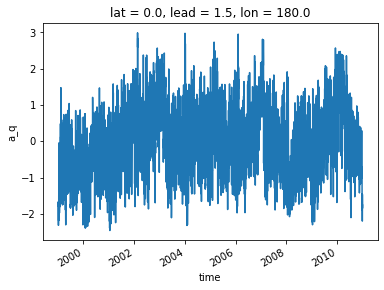

In [11]:
A.a_q.isel(lon=60,lat=10, lead=0).plot()

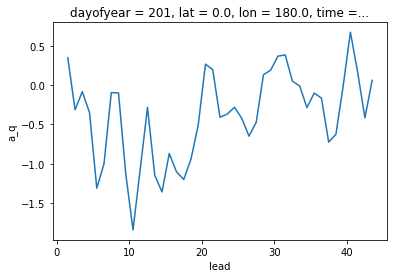

In [15]:
A.a_q.isel(lon=60,lat=10, time=200).plot()

In [9]:
cnt_1 = 1

In [10]:
cnt_2 = 0

In [11]:
resolucion_scale = 2  # 1-->normal (1.5x1.5), 2--> 200% (3x3), 4 --> 400% (6x6) 

In [12]:
MODEL_DATA_X_pre  = "/home/brayan/DATA/S2S/raw_data/NCEP/reforecast/control/pressure_level_1.q/pressure_level_1_q_L1_P20.nc"
MODEL_DATA_X_post = "/home/brayan/DATA/S2S/raw_data/NCEP/reforecast/control/pressure_level_1.q/pressure_level_1_q_L2_P20.nc"

In [13]:
DATAX_0 = xr.open_dataset(MODEL_DATA_X_pre).sel(Y=slice(30,-30))
DATAX_1 = xr.open_dataset(MODEL_DATA_X_post).sel(Y=slice(30,-30))

# Convertir a esfuerzo de vientos  # SOlo cuando hay cuatros variables para activar
if dataset == "10m_above_ground":
    TX_0, TY_0 = wind_to_stress( getattr(DATAX_0,"10u"), getattr(DATAY_0,"10v"))
    TX_1, TY_1 = wind_to_stress( getattr(DATAX_1,"10u"), getattr(DATAY_1,"10v"))    
else:
    TX_0 = getattr(DATAX_0, list((dic_inf.keys()))[0]).values
    TX_1 = getattr(DATAX_1, list((dic_inf.keys()))[0]).values
    TY_0 = getattr(DATAY_0, list((dic_inf.keys()))[0]).values
    TY_1 = getattr(DATAY_1, list((dic_inf.keys()))[0]).values

In [14]:
TX_0 = np.float32(getattr(DATAX_0, list((dic_inf.keys()))[0]).values)
TX_1 = np.float32(getattr(DATAX_1, list((dic_inf.keys()))[0]).values)

In [15]:
# Hacer el calculo para el promedio diario
TX_array                      =  xr.DataArray((TX_0.squeeze().reshape((TX_0.shape[0],1,TX_0.shape[-2],TX_0.shape[-1]))[:,:,::-1,:] + TX_1.squeeze().reshape((TX_0.shape[0],1,TX_0.shape[-2],TX_0.shape[-1]))[:,:,::-1,:])/2,  ###La inversion en lat se hace porque la latitud esta en orden descendente
                                              coords=[DATAX_0.S, np.array([cnt_1+0.5]) , DATAX_0.Y.values[::-1], DATAX_0.X],
                                              dims=["time","lead","lat","lon"])  

In [16]:
# Liberar espacio de memoria
DATAX_0.close()
DATAX_1.close()
del TX_0
del TX_1 
gc.collect()

102

In [120]:
# Se hace una interpolacion en el tiempo para algunos datos faltantes (generalmente en la dimension tiempo)
# dates_ = pd.date_range(str(TX_array.time.values[0])[:10],str(TX_array.time.values[-1])[:10], freq="D")

In [17]:
# Se hace una interpolacion en el tiempo para algunos datos faltantes (generalmente en la dimension tiempo)
TX_array_fill = TX_array.interpolate_na(dim="time", method="cubic", fill_value="extrapolate")

In [18]:
TX_array.close()
gc.collect()

22

In [19]:
# Regrillado del dataset (bajar resolucion)
if resolucion_scale > 1:
    ds_RES         = xr.Dataset(
                                {'lon':(['lon'], np.arange(TX_array_fill.lon.values[0],TX_array_fill.lon.values[-1], 1.5*resolucion_scale)),  
                                 'lat':(['lat'], np.arange(TX_array_fill.lat.values[0],TX_array_fill.lat.values[-1], 1.5*resolucion_scale))}  ## 1.5 es el anchod e grilla original
                                )
    regridder      = xe.Regridder(TX_array_fill, ds_RES, "bilinear") 
    regridder.clean_weight_file() 
    TX_res         = regridder(TX_array_fill).values    
    TX_array_RES   =  xr.DataArray(np.float32(TX_res),
                                   coords=[TX_array_fill.time, np.array([cnt_1+0.5]) , ds_RES.lat, ds_RES.lon],
                                   dims=["time","lead","lat","lon"])

    # Liberar espacio de memoria
    TX_array_fill.close()
    del TX_res
    gc.collect()    
else:
    TX_array_RES = TX_array_fill

Create weight file: bilinear_41x240_20x120.nc
Remove file bilinear_41x240_20x120.nc


In [27]:
# Calculo de Anomalias y Climatologias
TX_anom_RES, TX_Clim_RES = anom_clim( TX_array_RES, cnt_1)
# TX_array_MOM             = TX_anom_RES.chunk(chunks={'time': 1})                        

In [37]:
TX_array_RES.close()
gc.collect()  

747

In [38]:
# Extraemos la media y escalamos respecto a la desviacion estandar, si es una variable oceanica entonces devuelve cero
TX_anom_std   = ((TX_anom_RES-TX_anom_RES.mean("time"))/TX_anom_RES.std("time")).fillna(0)  #Por ahora aplicaremos la normalizacion estandar, pero debemos analizar otras opciones  #https://empresas.blogthinkbig.com/precauciones-la-hora-de-normalizar/

In [41]:
ANOM_X                   = xr.Dataset({"a_"+list((dic_inf.keys()))[0]: TX_anom_std})
CLIM_X                   = xr.Dataset({"clim_"+list((dic_inf.keys()))[0]: TX_Clim_RES, "mean": TX_anom_RES.mean("time"), "std": TX_anom_RES.std("time")})   

In [59]:
# Registro de datos
check_dir(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+str(levels)+"/CLIMATOLOGIA/")
check_dir(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+str(levels)+"/ANOMALIAS/")

In [62]:
if cnt_1 == 1:
    CLIM_X.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"/CLIMATOLOGIA/"+f"Climatologia_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                   mode="w", consolidated=True)
    ANOM_X.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"/ANOMALIAS/"+f"Anomalias_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                   mode="w", consolidated=True)   
else:
    CLIM_X.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"/CLIMATOLOGIA/"+f"Climatologia_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                   mode="w", consolidated=True, append_dim="lead")
    ANOM_X.to_zarr(OUTPUT_DIR+type_sim+"/"+var_cat+"."+list((dic_inf.keys()))[0]+"/ANOMALIAS/"+f"Anomalias_{str(ANOM_X.time.values[0])[:4]}_{str(ANOM_X.time.values[-1])[:4]}_x"+str(resolucion_scale)+".zarr",
                   mode="w", consolidated=True, append_dim="lead")       

In [ ]:
ANOM_X.close()
CLIM_X.close()
gc.collect()

In [11]:
list((dic_inf.keys()))[0]

'q'

In [12]:
levels

850

In [1]:
1

1

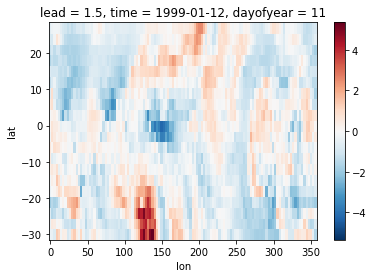

In [40]:
TX_anom_std.isel(time=10).plot()

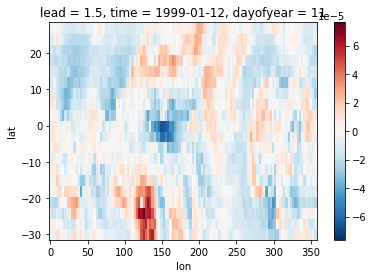

In [34]:
TX_anom_RES.isel(time=10).plot()

In [145]:
cnt_1

1

In [124]:
# Si la variable es oceanica, entonces se rellena los nans con ceros
if np.count_nonzero(np.isnan(TX_array_fill.isel(time=np.random.randint(0, high = TX_array_fill.shape[0])))) > 0: 
    TX_array_fill = TX_array_fill.fillna(0)
    print("Variable oceanica ejecutandose")
    
#Message
if np.count_nonzero(np.isnan(TX_array_fill)) == 0:
    print("El dataset esta limpio")
else: 
    print("TOdavia existen NANs")

El dataset esta limpio


In [ ]:
    for type_sim, v_2 in v_1.items():
        for type_ini, v_3 in v_2.items():
            for var_cat, v_4 in v_3.items():
                dic_inf = {}
                for sc, vs  in zip(list(v_4.keys()),list(v_4.values())): 
                    dic_inf[sc] = vs
                    
                if type_ini == "control":
                    v_5 = dic_inf["10u"]  #Se asume que ambas suvbcategorias tienen el mismo grillado L
                    des = list(v_5.keys())
                    for cnt_1 in range(v_5[des[0]].shape[0]-1):
                        MODEL_DATA_X_pre   = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[0]}/{dataset}_{list(v_4.keys())[0]}_{des[0]}{str(cnt_1)}.nc"
                        MODEL_DATA_Y_pre   = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[1]}/{dataset}_{list(v_4.keys())[1]}_{des[0]}{str(cnt_1)}.nc"
                        MODEL_DATA_X_post  = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[0]}/{dataset}_{list(v_4.keys())[0]}_{des[0]}{str(cnt_1+1)}.nc"
                        MODEL_DATA_Y_post  = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[1]}/{dataset}_{list(v_4.keys())[1]}_{des[0]}{str(cnt_1+1)}.nc"                        
                        
                        # Leemos los datos desde el disco duro
                        DATAX_0 = xr.open_dataset(MODEL_DATA_X_pre).sel(Y=slice(30,-30), X=slice(90,300))
                        DATAY_0 = xr.open_dataset(MODEL_DATA_Y_pre).sel(Y=slice(30,-30), X=slice(90,300))
                        DATAX_1 = xr.open_dataset(MODEL_DATA_X_post).sel(Y=slice(30,-30), X=slice(90,300))
                        DATAY_1 = xr.open_dataset(MODEL_DATA_Y_post).sel(Y=slice(30,-30), X=slice(90,300))                        
                        
                        # Convertir a esfuerzo de vientos
                        TX_0, TY_0 = wind_to_stress( getattr(DATAX_0,"10u"), getattr(DATAY_0,"10v"))
                        TX_1, TY_1 = wind_to_stress( getattr(DATAX_1,"10u"), getattr(DATAY_1,"10v"))                        
                        
                        # Hacer el calculo para el promedio diario
                        TX_array                      =  xr.DataArray((TX_0[:,:,::-1,:] + TX_1[:,:,::-1,:])/2,
                                                                      coords=[DATAX_0.S, np.array([cnt_1+0.5]) , DATAX_0.Y.values[::-1], DATAX_0.X],
                                                                      dims=["time","lead","lat","lon"])
                        TY_array                      =  xr.DataArray((TY_0[:,:,::-1,:] + TY_1[:,:,::-1,:])/2,
                                                                      coords=[DATAX_0.S, np.array([cnt_1+0.5]) , DATAX_0.Y.values[::-1], DATAX_0.X],
                                                                      dims=["time","lead","lat","lon"])                        
                        
                        # Liberar espacio de memoria
                        DATAX_0.close()
                        DATAY_0.close()
                        DATAX_1.close()
                        DATAY_1.close()
                        del TX_0
                        del TX_1 
                        del TY_0
                        del TY_1 
                        gc.collect()
                        
                        # Regrillado y relleno de datos
                        ds_MOM         = xr.Dataset(
                                                    {'lon':(['lon'], np.arange(90,299,1)), 'lat':(['lat'], np.arange(-30,30.5,0.5))}
                                                    )
                        regridder      = xe.Regridder(TX_array, ds_MOM, "bilinear") 
                        regridder.clean_weight_file() 
                        date_current = pd.date_range( str(TX_array.time.values[0])[:10], str(TX_array.time.values[-1])[:10], freq="D")
                        TX_MOM = regridder(TX_array).interpolate_na(dim="lon", method="zero", fill_value="extrapolate").interpolate_na(dim="time", method="cubic", fill_value="extrapolate").values
                        TY_MOM = regridder(TY_array).interpolate_na(dim="lon", method="zero", fill_value="extrapolate").interpolate_na(dim="time", method="cubic", fill_value="extrapolate").values                        
                        TX_array_MOM                      =  xr.DataArray(np.float32(TX_MOM),
                                                                      coords=[TX_array.time, np.array([cnt_1+0.5]) , ds_MOM.lat, ds_MOM.lon],
                                                                      dims=["time","lead","lat","lon"])
                        TY_array_MOM                      =  xr.DataArray(np.float32(TY_MOM),
                                                                      coords=[TY_array.time, np.array([cnt_1+0.5]) , ds_MOM.lat, ds_MOM.lon],
                                                                      dims=["time","lead","lat","lon"])
                        
                        # Liberar espacio de memoria
                        TX_array.close()
                        TY_array.close()
                        del TX_MOM
                        del TY_MOM
                        gc.collect()
                        
                        # Calculo de Anomalias y Climatologias
                        TX_anom_MOM, TX_Clim_MOM = anom_clim( TX_array_MOM, int(TX_array_MOM.lead.values[0]))
                        TY_anom_MOM, TY_Clim_MOM = anom_clim( TY_array_MOM, int(TY_array_MOM.lead.values[0]))
                        TX_array_MOM             = TX_array_MOM.chunk(chunks={'time': 1})
                        TY_array_MOM             = TY_array_MOM.chunk(chunks={'time': 1})                        
                        TAU                      = xr.Dataset({'taux': TX_array_MOM, 'tauy': TY_array_MOM})
                        ATAU                     = xr.Dataset({'ataux': TX_anom_MOM, 'atauy': TY_anom_MOM})
                        TAU_CLIM                 = xr.Dataset({'tx_clim': TX_Clim_MOM, 'ty_clim': TY_Clim_MOM})                        
                        
                        # Registro de datos
                        TAU_CLIM.to_netcdf(OUTPUT_DIR+"CLIMATOLOGIA/"+f"Climatologia_{str(TX_array_MOM.time.values[0])[:4]}_{str(TX_array_MOM.time.values[-1])[:4]}_lead_{cnt_1}_M0.nc")
                        for enum, date_ in enumerate(TX_array_MOM.time.values):
                            # if enum == 5:
                            #     break
                            check_dir(OUTPUT_DIR+"TAU/"+str(date_)[:4], str(date_)[:10])
                            check_dir(OUTPUT_DIR+"ANOMALIAS/"+str(date_)[:4], str(date_)[:10])
                            TAU.isel(time=enum).to_netcdf(OUTPUT_DIR+"TAU/"+str(date_)[:4]+"/"+str(date_)[:10]+"/"+str(date_)[:10]+f"-lead_{cnt_1}_M0.nc")
                            ATAU.isel(time=enum).to_netcdf(OUTPUT_DIR+"ANOMALIAS/"+str(date_)[:4]+"/"+str(date_)[:10]+"/"+str(date_)[:10]+f"-lead_{cnt_1}_M0.nc")
                            print(enum, str(date_)[:10])  
                            
                        print(MODEL_DATA_X_pre)
                        print(MODEL_DATA_Y_pre)
                        print(MODEL_DATA_X_post)
                        print(MODEL_DATA_Y_post)  
                        print("paso")
                else:
                    v_5 = dic_inf["10u"]  #Se asume que ambas suvbcategorias tienen el mismo grillado L
                    des = list(v_5.keys())
                    for cnt_1 in range(v_5[des[0]].shape[0]-1):
                        for cnt_2,_ in enumerate(v_5[des[1]]):
                            MODEL_DATA_X_pre  = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[0]}/{dataset}_{list(v_4.keys())[0]}_{des[0]}{str(cnt_1)}_{des[1]}{str(cnt_2)}.nc"
                            MODEL_DATA_Y_pre  = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[1]}/{dataset}_{list(v_4.keys())[1]}_{des[0]}{str(cnt_1)}_{des[1]}{str(cnt_2)}.nc"
                            MODEL_DATA_X_post = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[0]}/{dataset}_{list(v_4.keys())[0]}_{des[0]}{str(cnt_1+1)}_{des[1]}{str(cnt_2)}.nc"
                            MODEL_DATA_Y_post = INPUT_DATA + f"{model_name}/{type_sim}/{type_ini}/{var_cat}.{list(v_4.keys())[1]}/{dataset}_{list(v_4.keys())[1]}_{des[0]}{str(cnt_1+1)}_{des[1]}{str(cnt_2)}.nc"                            
                    